In [1099]:
# Import the libraries we need for this lab

# Allows us to use arrays to manipulate and store data
import numpy as np
# PyTorch Library
import torch
# PyTorch Neural Network
import torch.nn as nn
# Allows us to use activation functions
import torch.nn.functional as F
# Used to graph data and loss curves
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
# Used to help create the dataset and perform mini-batch
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

import pandas as pd
from sklearn.preprocessing import StandardScaler as ss, MinMaxScaler as mms
from sklearn.preprocessing import LabelEncoder as le

from IPython.display import clear_output

---

#### Sample a dataframe into training and testing sets by specifying the count of each class of the binary target variable for both sets. It includes the option to automaticly fill the "1" class members or to equalize the number of members.

binary_sample(df, target, categories=[[0], [1]],
                  testing=[1000, 1000], training=[5000, 5000],
                  fill_train_1=False, equal_train_0=False,
                  test_set=None, print_shapes=False, invert=False)

In [1124]:
def binary_sample(df, target, categories=[[0], [1]],
                  testing=[1000, 1000], training=[5000, 5000],
                  fill_train_1=False, equal_train_0=False,
                  test_set=None, print_shapes=False, invert=False, path=None):
    
    if invert:
        training=testing.copy()
        testing=[None, None]
    
    print('Extraindo Index por Categoria...')
    index_0 = df[df[target].isin(categories[0])].index
    index_1 = df[df[target].isin(categories[1])].index
        
    if type(test_set)==type(None):
        return_test=True
        print('Extraindo Index Teste - {} para {}...'.format(testing[0], testing[1]))
        test_index = list(np.random.choice(index_0, testing[0], replace=False)) + list(np.random.choice(index_1, testing[1], replace=False))
        print('Extraindo Tabela de Teste...')
        test_set = df.loc[test_index]
    
    else:
        return_test=False
        test_index = test_set.index.tolist()        
    
    print('Extraindo Index Treinamento (Excluindo Index Teste) - {} para {}...'.format(training[0], training[1]))  
    
    index_1_train = list(set(index_1).difference(test_index))   # Está Invertido (1 depois 0)
    if not fill_train_1: index_1_train = list(np.random.choice(index_1_train, training[1], replace=False))
    
    index_0_train = list(set(index_0).difference(test_index))
    if equal_train_0: training[0] = len(index_1_train)
    index_0_train = list(np.random.choice(index_0_train, training[0], replace=False))
    
    train_index = index_0_train + index_1_train
    
    print('Extracting Training Sample...')
    train_set = df.loc[train_index]    
        
    clear_output(wait=True)
    if print_shapes:
        print('Original Shape:')
        print(ano9_base.shape)
        print('Test Set Shape:')
        print(test_set.shape)
        print('Train Set Shape:')
        print(train_set.shape)
        print('')

    
    sets = [df, train_set, test_set]
    report_cols = ['Original', 'Training', 'Testing']
    
    print('Target Classes Count:')
    if invert: 
        report_cols[1], report_cols[2] = report_cols[2], report_cols[1]

    relatorio_amostragem = pd.concat([data_set[target]
                                      .value_counts()
                                      .to_frame()
                                      .rename(columns={target:col_name}) for data_set, col_name in zip(sets, report_cols)], axis=1)
    relatorio_amostragem.index=[f'Class {k}' for k in relatorio_amostragem.index]
    display(relatorio_amostragem)
    if type(path)!=type(None): dfi.export(relatorio_amostragem, path)
   
    inter = set(train_set.index).intersection(test_set.index)
    if inter: print('\nLeaked Information!')
    else: print('\nNo Information Leaked to the Testing Set.')

    if not return_test: return train_set
    return train_set, test_set

---

# GET DATA

## Original Data Text

In [51]:
text = '''1. ID is number of record in original database. Cannot be related to participant. It can be used for reference only.

2. Age (Real) is age of participant and has one of the values:
Value Meaning Cases Fraction
-0.95197 18-24 643 34.11%
-0.07854 25-34 481 25.52%
0.49788 35-44 356 18.89%
1.09449 45-54 294 15.60%
1.82213 55-64 93 4.93%
2.59171 65+ 18 0.95%
Descriptive statistics
Min Max Mean Std.dev.
-0.95197 2.59171 0.03461 0.87813

3. Gender (Real) is gender of participant:
Value Meaning Cases Fraction
0.48246 Female 942 49.97%
-0.48246 Male 943 50.03%
Descriptive statistics
Min Max Mean Std.dev.
-0.48246 0.48246 -0.00026 0.48246

4. Education (Real) is level of education of participant and has one of the values:
Value Meaning Cases Fraction
-2.43591 Left school before 16 years 28 1.49%
-1.73790 Left school at 16 years 99 5.25%
-1.43719 Left school at 17 years 30 1.59%
-1.22751 Left school at 18 years 100 5.31%
-0.61113 Some college or university, no certificate or degree 506 26.84%
-0.05921 Professional certificate/ diploma 270 14.32%
0.45468 University degree 480 25.46%
1.16365 Masters degree 283 15.01%
1.98437 Doctorate degree 89 4.72%
Descriptive statistics
Min Max Mean Std.dev.
-2.43591 1.98437 -0.00379 0.95004

5. Country (Real) is country of current residence of participant and has one of the values:
Value Meaning Cases Fraction
-0.09765 Australia 54 2.86%
0.24923 Canada 87 4.62%
-0.46841 New Zealand 5 0.27%
-0.28519 Other 118 6.26%
0.21128 Republic of Ireland 20 1.06%
0.96082 UK 1044 55.38%
-0.57009 USA 557 29.55%
Descriptive statistics
Min Max Mean Std.dev.
-0.57009 0.96082 0.35554 0.70015

6. Ethnicity (Real) is ethnicity of participant and has one of the values:
Value Meaning Cases Fraction
-0.50212 Asian 26 1.38%
-1.10702 Black 33 1.75%
1.90725 Mixed-Black/Asian 3 0.16%
0.12600 Mixed-White/Asian 20 1.06%
-0.22166 Mixed-White/Black 20 1.06%
0.11440 Other 63 3.34%
-0.31685 White 1720 91.25%
Descriptive statistics
Min Max Mean Std.dev.
-1.10702 1.90725 -0.30958 0.16618

7. Nscore (Real) is NEO-FFI-R Neuroticism. Possible values are presented in table below:
Nscore Cases Value Nscore Cases Value Nscore Cases Value
12 1 -3.46436 29 60 -0.67825 46 67 1.02119
13 1 -3.15735 30 61 -0.58016 47 27 1.13281
14 7 -2.75696 31 87 -0.46725 48 49 1.23461
15 4 -2.52197 32 78 -0.34799 49 40 1.37297
16 3 -2.42317 33 68 -0.24649 50 24 1.49158
17 4 -2.34360 34 76 -0.14882 51 27 1.60383
18 10 -2.21844 35 69 -0.05188 52 17 1.72012
19 16 -2.05048 36 73 0.04257 53 20 1.83990
20 24 -1.86962 37 67 0.13606 54 15 1.98437
21 31 -1.69163 38 63 0.22393 55 11 2.12700
22 26 -1.55078 39 66 0.31287 56 10 2.28554
23 29 -1.43907 40 80 0.41667 57 6 2.46262
24 35 -1.32828 41 61 0.52135 58 3 2.61139
25 56 -1.19430 42 77 0.62967 59 5 2.82196
26 57 -1.05308 43 49 0.73545 60 2 3.27393
27 65 -0.92104 44 51 0.82562
28 70 -0.79151 45 37 0.91093
Descriptive statistics
Min Max Mean Std.dev.
-3.46436 3.27393 0.00004 0.99808

8. Escore (Real) is NEO-FFI-R Extraversion. Possible values are presented in table below:
Escore Cases Value Escore Cases Value Escore Cases Value
16 2 -3.27393 31 55 -1.23177 45 91 0.80523
18 1 -3.00537 32 52 -1.09207 46 69 0.96248
19 6 -2.72827 33 77 -0.94779 47 64 1.11406
20 3 -2.53830 34 68 -0.80615 48 62 1.28610
21 3 -2.44904 35 58 -0.69509 49 37 1.45421
22 8 -2.32338 36 89 -0.57545 50 25 1.58487
23 5 -2.21069 37 90 -0.43999 51 34 1.74091
24 9 -2.11437 38 106 -0.30033 52 21 1.93886
25 4 -2.03972 39 107 -0.15487 53 15 2.12700
26 21 -1.92173 40 130 0.00332 54 10 2.32338
27 23 -1.76250 41 116 0.16767 55 9 2.57309
28 23 -1.63340 42 109 0.32197 56 2 2.85950
29 32 -1.50796 43 105 0.47617 58 1 3.00537
30 38 -1.37639 44 103 0.63779 59 2 3.27393
Descriptive statistics
Min Max Mean Std.dev.
-3.27393 3.27393 -0.00016 0.99745

9. Oscore (Real) is NEO-FFI-R Openness to experience. Possible values are presented in table below:
Oscore Cases Value Oscore Cases Value Oscore Cases Value
24 2 -3.27393 38 64 -1.11902 50 83 0.58331
26 4 -2.85950 39 60 -0.97631 51 87 0.72330
28 4 -2.63199 40 68 -0.84732 52 87 0.88309
29 11 -2.39883 41 76 -0.71727 53 81 1.06238
30 9 -2.21069 42 87 -0.58331 54 57 1.24033
31 9 -2.09015 43 86 -0.45174 55 63 1.43533
32 13 -1.97495 44 101 -0.31776 56 38 1.65653
33 23 -1.82919 45 103 -0.17779 57 34 1.88511
34 25 -1.68062 46 134 -0.01928 58 19 2.15324
35 26 -1.55521 47 107 0.14143 59 13 2.44904
36 39 -1.42424 48 116 0.29338 60 7 2.90161
37 51 -1.27553 49 98 0.44585
Descriptive statistics
Min Max Mean Std.dev.
-3.27393 2.90161 -0.00053 0.99623

10. Ascore (Real) is NEO-FFI-R Agreeableness. Possible values are presented in table below:
Ascore Cases Value Ascore Cases Value Ascore Cases Value
12 1 -3.46436 34 42 -1.34289 48 104 0.76096
16 1 -3.15735 35 45 -1.21213 49 85 0.94156
18 1 -3.00537 36 62 -1.07533 50 68 1.11406
23 1 -2.90161 37 83 -0.91699 51 58 1.2861
24 2 -2.78793 38 82 -0.76096 52 39 1.45039
25 1 -2.70172 39 102 -0.60633 53 36 1.61108
26 7 -2.53830 40 98 -0.45321 54 36 1.81866
27 7 -2.35413 41 114 -0.30172 55 16 2.03972
28 8 -2.21844 42 101 -0.15487 56 14 2.23427
29 13 -2.07848 43 105 -0.01729 57 8 2.46262
30 18 -1.92595 44 118 0.13136 58 7 2.75696
31 24 -1.77200 45 112 0.28783 59 1 3.15735
32 30 -1.62090 46 100 0.43852 60 1 3.46436
33 34 -1.47955 47 100 0.59042
Descriptive statistics
Min Max Mean Std.dev.
-3.46436 3.46436 -0.00024 0.99744

11. Cscore (Real) is NEO-FFI-R Conscientiousness. Possible values are presented in table below:
Cscore Cases Value Cscore Cases Value Cscore Cases Value
17 1 -3.46436 32 39 -1.25773 46 113 0.58489
19 1 -3.15735 33 49 -1.13788 47 95 0.7583
20 3 -2.90161 34 55 -1.01450 48 95 0.93949
21 2 -2.72827 35 55 -0.89891 49 76 1.13407
22 5 -2.57309 36 69 -0.78155 50 47 1.30612
23 5 -2.42317 37 81 -0.65253 51 43 1.46191
24 6 -2.30408 38 77 -0.52745 52 34 1.63088
25 9 -2.18109 39 87 -0.40581 53 28 1.81175
26 13 -2.04506 40 97 -0.27607 54 27 2.04506
27 13 -1.92173 41 99 -0.14277 55 13 2.33337
28 25 -1.78169 42 105 -0.00665 56 8 2.63199
29 24 -1.64101 43 90 0.12331 57 3 3.00537
30 29 -1.51840 44 111 0.25953 59 1 3.46436
31 41 -1.38502 45 111 0.41594
Descriptive statistics
Min Max Mean Std.dev.
-3.46436 3.46436 -0.00039 0.99752

12. Impulsive (Real) is impulsiveness measured by BIS-11. Possible values are presented in table below:
Impulsiveness Cases Fraction
-2.55524 20 1.06%
-1.37983 276 14.64%
-0.71126 307 16.29%
-0.21712 355 18.83%
0.19268 257 13.63%
0.52975 216 11.46%
0.88113 195 10.34%
1.29221 148 7.85%
1.86203 104 5.52%
2.90161 7 0.37%
Descriptive statistics
Min Max Mean Std.dev.
-2.55524 2.90161 0.00721 0.95446

13. SS (Real) is sensation seeing measured by ImpSS. Possible values are presented in table below:
SS Cases Fraction
-2.07848 71 3.77%
-1.54858 87 4.62%
-1.18084 132 7.00%
-0.84637 169 8.97%
-0.52593 211 11.19%
-0.21575 223 11.83%
0.07987 219 11.62%
0.40148 249 13.21%
0.76540 211 11.19%
1.22470 210 11.14%
1.92173 103 5.46%
Descriptive statistics
Min Max Mean Std.dev.
-2.07848 1.92173 -0.00329 0.96370

14. Alcohol is class of alcohol consumption. It is output attribute with following distribution of classes.

15. Amphet is class of amphetamines consumption. It is output attribute with following distribution of classes.

16. Amyl is class of amyl nitrite consumption. It is output attribute with following distribution of classes.

17. Benzos is class of benzodiazepine consumption. It is output attribute with following distribution of classes:
Value Class Alcohol Amphet Amyl Benzos
Cases Fraction Cases Fraction Cases Fraction Cases Fraction
CL0 Never Used 34 1.80% 976 51.78% 1305 69.23% 1000 53.05%
CL1 Used over a Decade Ago 34 1.80% 230 12.20% 210 11.14% 116 6.15%
CL2 Used in Last Decade 68 3.61% 243 12.89% 237 12.57% 234 12.41%
CL3 Used in Last Year 198 10.50% 198 10.50% 92 4.88% 236 12.52%
CL4 Used in Last Month 287 15.23% 75 3.98% 24 1.27% 120 6.37%
CL5 Used in Last Week 759 40.27% 61 3.24% 14 0.74% 84 4.46%
CL6 Used in Last Day 505 26.79% 102 5.41% 3 0.16% 95 5.04%

18. Caff is class of caffeine consumption. It is output attribute with following distribution of classes.

19. Cannabis is class of cannabis consumption. It is output attribute with following distribution of classes.

20. Choc is class of chocolate consumption. It is output attribute with following distribution of classes.

21. Coke is class of cocaine consumption. It is output attribute with following distribution of classes:
Value Class Caff Cannabis Choc Coke
Cases Fraction Cases Fraction Cases Fraction Cases Fraction
CL0 Never Used 27 1.43% 413 21.91% 32 1.70% 1038 55.07%
CL1 Used over a Decade Ago 10 0.53% 207 10.98% 3 0.16% 160 8.49%
CL2 Used in Last Decade 24 1.27% 266 14.11% 10 0.53% 270 14.32%
CL3 Used in Last Year 60 3.18% 211 11.19% 54 2.86% 258 13.69%
CL4 Used in Last Month 106 5.62% 140 7.43% 296 15.70% 99 5.25%
CL5 Used in Last Week 273 14.48% 185 9.81% 683 36.23% 41 2.18%
CL6 Used in Last Day 1385 73.47% 463 24.56% 807 42.81% 19 1.01%

22. Crack is class of crack consumption. It is output attribute with following distribution of classes.

23. Ecstasy is class of ecstasy consumption. It is output attribute with following distribution of classes.

24. Heroin is class of heroin consumption. It is output attribute with following distribution of classes.

25. Ketamine is class of ketamine consumption. It is output attribute with following distribution of classes:
Value Class Crack Ecstasy Heroin Ketamine
Cases Fraction Cases Fraction Cases Fraction Cases Fraction
CL0 Never Used 1627 86.31% 1021 54.16% 1605 85.15% 1490 79.05%
CL1 Used over a Decade Ago 67 3.55% 113 5.99% 68 3.61% 45 2.39%
CL2 Used in Last Decade 112 5.94% 234 12.41% 94 4.99% 142 7.53%
CL3 Used in Last Year 59 3.13% 277 14.69% 65 3.45% 129 6.84%
CL4 Used in Last Month 9 0.48% 156 8.28% 24 1.27% 42 2.23%
CL5 Used in Last Week 9 0.48% 63 3.34% 16 0.85% 33 1.75%
CL6 Used in Last Day 2 0.11% 21 1.11% 13 0.69% 4 0.21%

26. Legalh is class of legal highs consumption. It is output attribute with following distribution of classes

27. LSD is class of alcohol consumption. It is output attribute with following distribution of classes

28. Meth is class of methadone consumption. It is output attribute with following distribution of classes.

29. Mushrooms is class of magic mushrooms consumption. It is output attribute with following distribution of classes:
Value Class Legalh LSD Meth Mushrooms
Cases Fraction Cases Fraction Cases Fraction Cases Fraction
CL0 Never Used 1094 58.04% 1069 56.71% 1429 75.81% 982 52.10%
CL1 Used over a Decade Ago 29 1.54% 259 13.74% 39 2.07% 209 11.09%
CL2 Used in Last Decade 198 10.50% 177 9.39% 97 5.15% 260 13.79%
CL3 Used in Last Year 323 17.14% 214 11.35% 149 7.90% 275 14.59%
CL4 Used in Last Month 110 5.84% 97 5.15% 50 2.65% 115 6.10%
CL5 Used in Last Week 64 3.40% 56 2.97% 48 2.55% 40 2.12%
CL6 Used in Last Day 67 3.55% 13 0.69% 73 3.87% 4 0.21%

30. Nicotine is class of nicotine consumption. It is output attribute with following distribution of classes.

31. Semer is class of fictitious drug Semeron consumption. It is output attribute with following distribution of classes.

32. VSA is class of volatile substance abuse consumption. It is output attribute with following distribution of classes:
Value Class Nicotine S'''

---

# Extracting Variables Categories Legends

### Drug Categories Legend

In [183]:
drug_legend = '''CL0 Never Used
CL1 Used over a Decade Ago
CL2 Used in Last Decade
CL3 Used in Last Year
CL4 Used in Last Month
CL5 Used in Last Week
CL6 Used in Last Day'''

In [184]:
drug_categories_dict = {item.split(' ')[0]: ' '.join(item.split(' ')[1:]) for item in drug_legend.split('\n')}; drug_categories_dict

{'CL0': 'Never Used',
 'CL1': 'Used over a Decade Ago',
 'CL2': 'Used in Last Decade',
 'CL3': 'Used in Last Year',
 'CL4': 'Used in Last Month',
 'CL5': 'Used in Last Week',
 'CL6': 'Used in Last Day'}

### Descriptors Categories Legends

In [195]:
IDS = ['Age', 'Gender', 'Education', 'Country', 'Ethnicity']

legends = dict()
for feature_index in range(1,6):
    
    feat_dict = dict()
    for item in text.split('\n\n')[feature_index].split('\n')[2:-3]:    
        feat_dict[float(item.split(' ')[0])] = ' '.join(item.split(' ')[1:-2])

    legends[IDS[feature_index-1]] = feat_dict

In [196]:
legends['Age']

{-0.95197: '18-24',
 -0.07854: '25-34',
 0.49788: '35-44',
 1.09449: '45-54',
 1.82213: '55-64',
 2.59171: '65+'}

---

# Data Cleaning

In [197]:
drug = pd.read_csv('/Users/luisr/Desktop/drug_consumption.data', delimiter=',')

In [198]:
columns = [i.split()[1] for i in text.split('\n\n')]
drug = drug.T.reset_index().T
drug.columns = columns
drug[drug.columns[6:13]] = drug[drug.columns[6:13]].astype(float)
drug.drop('index', inplace=True)

for col in drug.columns[1:6]: drug[col] = [round(item, 5) for item in drug[col]]

In [199]:
feats = drug.columns[:13].tolist(); print(feats)

['ID', 'Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS']


In [201]:
drug_cols = drug.columns[13:].tolist(); print(drug_cols)

['Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caff', 'Cannabis', 'Choc', 'Coke', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'Semer', 'VSA']


---

# Label Encoding Categories

In [203]:
for col in drug.columns[1:6]:
    LE = le().fit(list(legends[col].keys()))
    drug[col] = LE.transform(drug[col])

In [204]:
for col in drug.columns[13:]:
    LE = le().fit(list(drug_categories_dict.keys()))
    drug[col] = LE.transform(drug[col].astype(str))

In [1164]:
drug.head()

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,...,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,2,1,0,8,6,2,-0.67825,1.93886,1.43533,0.76096,...,4,0,2,0,2,3,0,4,0,0
1,3,2,0,5,6,2,-0.46725,0.80523,-0.84732,-1.62090,...,0,0,0,0,0,0,1,0,0,0
2,4,0,1,7,6,2,-0.14882,-0.80615,-0.01928,0.59042,...,0,0,2,0,0,0,0,2,0,0
3,5,2,1,8,6,2,0.73545,-1.63340,-0.45174,-0.30172,...,1,0,0,1,0,0,2,2,0,0
4,6,5,1,3,5,2,-0.67825,-0.30033,-1.55521,2.03972,...,0,0,0,0,0,0,0,6,0,0


---

# Feature Engineering

### Binary Category Conversion

In [ ]:
for col in drug.columns[13:]:    
#    drug[col+' ever'] = [0 if a!='CL0' else 1 for a in drug[col]]
#    drug[col+' ever'] = [0 if a in ['CL0'] else 1 for a in drug[col]]
    pass

---

# Torch Dataset Class

In [1210]:
# Define the class XOR_Data

class Load_Data(Dataset):
    
    # Constructor
    # N_s is the size of the dataset
    def __init__(self, x, y):
        # Create a N_s by 2 array for the X values representing the coordinates
        self.x = torch.Tensor(x)
        # Create a N_s by 1 array for the class the X value belongs to
        self.y = torch.Tensor(y)
    
        self.len = y.size

    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the data
    def plot_2d(self, xy=[0,1], alpha=0.5):
        
        plt.plot(self.x[self.y[:, 0] == 0, xy[0]].numpy(),
                 self.x[self.y[:, 0] == 0, xy[1]].numpy(), 'o', label="y=0", alpha=alpha)
        plt.plot(self.x[self.y[:, 0] == 1, xy[0]].numpy(),
                 self.x[self.y[:, 0] == 1, xy[1]].numpy(), 'ro', label="y=1", alpha=alpha)
        plt.legend(); plt.grid(); plt.show()
    
    def plot_3d(self, xyz=[0,1,2], angles=range(0, 360, 12), angle_factor=8, alpha=0.6, figsize=(6,4)):
        
        for angle in angles:
            
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(projection='3d')
            ax.scatter(self.x[self.y[:, 0]==0, xyz[0]],
                       self.x[self.y[:, 0]==0, xyz[1]],
                       self.x[self.y[:, 0]==0, xyz[2]], 'o', alpha=alpha)

            ax.scatter(self.x[self.y[:, 0]==1, xyz[0]],
                       self.x[self.y[:, 0]==1, xyz[1]],
                       self.x[self.y[:, 0]==1, xyz[2]], 'ro', alpha=alpha)

            fig.tight_layout()
            
            ax.view_init(angle/angle_factor, angle)
            plt.show()
            plt.pause(0.001)
            clear_output(wait=True)
 

# Modeling

### Neural Net with One Hidden Layer

In [941]:
# Define the class Net with one hidden layer 

class Neural_Net(nn.Module):
    
    # Constructor
    def __init__(self, D_in, H, D_out):
        super(Neural_Net, self).__init__()
        # D_in is the input size of the first layer (size of input layer)
        # H is the output size of the first layer and the input size of the second layer (size of hidden layer)
        # D_out is the output size of the second layer (size of output layer)
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)

    # Prediction    
    def forward(self, x):
        # Puts x through first layer then sigmoid function
        x = torch.sigmoid(self.linear1(x)) 
        # Puts result of previous line through second layer then sigmoid function
        x = torch.sigmoid(self.linear2(x))
        # Output is a number between 0 and 1 due to the sigmoid function. Whichever the output is closer to, 0 or 1, is the class prediction
        return x

### Neural Net with "N" Hidden Layer

In [1100]:
# Create dataset object

class Neural_Net(nn.Module):
    
    # Constructor
    # Given a list of integers, Layers, we create layers of the neural network where each integer in Layers corresponds to the layers number of neurons
    def __init__(self, Layers):
        
        super(Neural_Net, self).__init__()
        
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers[:-1], Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))
    
    # Prediction
    # Puts the X value through each layer of the neural network while using the RELU activation function in between. The final output is not put through RELU.
    def forward(self, x, activation='sigmoid'):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            
            if l < L - 1:                
                if activation=='relu': x = F.relu(linear_transform(x))    
                elif activation=='sigmoid': x = torch.sigmoid(linear_transform(x))    

            else: x = torch.sigmoid(linear_transform(x))
        
        return x

In [1101]:
# Calculate the accuracy

def accuracy(model, data_set):
    # Rounds prediction to nearest integer 0 or 1
    # Checks if prediction matches the actual values and returns accuracy rate
    return np.mean(data_set.y.view(-1).numpy() == (model(data_set.x)[:, 0] > 0.5).numpy())

Define a function to train the model:


In [1219]:
# Function to Train the Model

def train(data_set, model, criterion, train_loader, optimizer, epochs=5, test_data=None):
    
    COST = []; ACC = []; test_ACC = []
    for epoch in range(epochs):
        
        clear_output(wait=True); print(f'Epoch: {epoch+1}/{epochs}')        
        total_loss=0
        for x, y in train_loader:

            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
            
            total_loss+=loss.item()

        ACC.append(accuracy(model, data_set))
        COST.append(total_loss)

# ------------------ Validation Data ---------

        if type(test_data)!=type(None): test_ACC.append(accuracy(model, test_data))    
        
# ------------ Result Visualization -------------

    # Prints Cost vs Epoch graph
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)
    
    # Prints Accuracy vs Epoch graph
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)

    if type(test_data)!=type(None):
        
        fig2, ax3 = plt.subplots()
        color = 'tab:green'
        ax3.plot(test_ACC, color=color)
        ax3.set_xlabel('epoch', color=color)
        ax3.set_ylabel('test_acc', color=color)
        ax3.tick_params(axis='y', color=color)
        fig2.tight_layout()
        
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

    return COST

In [1161]:
# Plot the data

def plot_decision_regions_2class(model,data_set):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1 , X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1 , X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    XX = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])

    yhat = np.logical_not((model(XX)[:, 0] > 0.5).numpy()).reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light, shading='auto')
    plt.plot(X[y[:, 0] == 0, 0], X[y[:, 0] == 0, 1], 'o', label='y=0')
    plt.plot(X[y[:, 0] == 1, 0], X[y[:, 0] == 1, 1], 'ro', label='y=1')
    plt.title("decision region")
    plt.legend()

## Loading Data

In [1206]:
train_set, test_set = binary_sample(  drug, target, categories=[[0], [1,2,3,4,5,6]],
                                      testing=[100, 100], training=[700, 700],
                                      fill_train_1=False, equal_train_0=False,
                                      test_set=None, print_shapes=False, invert=False, path=None
                                   )

Target Classes Count:


,Original,Training,Testing
Class 0,1020,700,100
Class 1,113,81,16
Class 2,234,187,30
Class 3,277,241,24
Class 4,156,126,18
Class 5,63,50,7
Class 6,21,15,5



No Information Leaked to the Testing Set.


In [1232]:
target=['Ecstasy', 'Cannabis'][1]

#Y = ((drug[[target]]!=0)+0).values.copy()
#X = drug[drug.columns[[1,2,3,4,5,6,7,8,9,10,11,12]]].values.copy()

Y = ((train_set[[target]]!=0)+0).values.copy()
X = train_set[train_set.columns[range(1,13)]].values.copy()

Y_test = ((test_set[[target]]!=0)+0).values.copy()
X_test = test_set[test_set.columns[range(1,13)]].values.copy()

data = Load_Data(X, Y)
test_data = Load_Data(X_test, Y_test)

In [ ]:
data.plot_2d([0,1], alpha=.7); # test_data.plot_2d([0,1])

test_data.plot_3d(angle_factor=24, alpha=0.3, figsize=(6,5))

## Building Model

In [1215]:
torch.manual_seed(0)

In [1233]:
n_categories = len(np.unique(data.y))
n_features = len(data.x[0])

Layers = [n_features] + [n_features*3]*3 + [n_categories-1]
#Layers = [3,50,1]
Layers

[12, 36, 36, 36, 1]

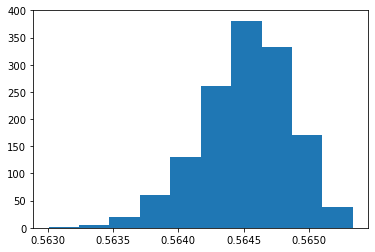

In [1234]:
model = Neural_Net(Layers)
#model = Neural_Net(n_features, 36, n_categories-1)
yhat = model(data.x)
plt.hist(yhat.detach().numpy()); plt.show()

## Training Model

Epoch: 50/50


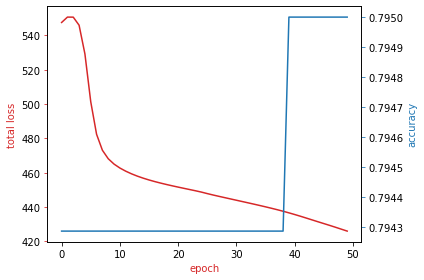

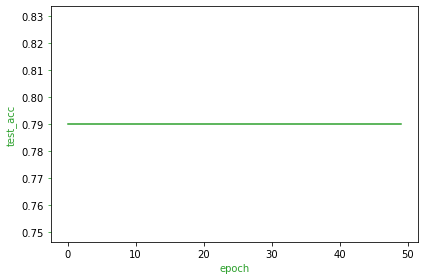

In [1235]:
# Train the model
learning_rate = 0.1

# We create a criterion which will measure loss
criterion = nn.BCELoss()

# Create an optimizer that updates model parameters using the learning rate and gradient
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Create a Data Loader for the training data with a batch size of 1 
train_loader = DataLoader(dataset=data, batch_size=1)
test_loader = DataLoader(dataset=test_data, batch_size=1)

# Using the training function train the model on 500 epochs
LOSS = train(data, model, criterion, train_loader, optimizer, epochs=50, test_data=test_data)

In [ ]:
# Plot the data with decision boundaries
plot_decision_regions_2class(model, data)

<!--Empty Space for separating topics-->
